In [1]:
import multiprocessing
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import warnings

import tensorflow as tf
from tensorflow.core.util import event_pb2

warnings.filterwarnings("ignore")

In [11]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
RUNS_DIR = f"{BASE_DIR}/runs"

THRESHOLDS = {"v0": 1e-1, "v1": np.exp(1)}

EXP_ID = "v1-optim-L-60k"
THRESHOLD = THRESHOLDS[EXP_ID.split("-")[0]]
LOG = True
TOP_K = 3

In [5]:
algos = ["ddpg", "dpg", "ppo", "reinforce", "sac", "td3", "trpo", "tqc"]

In [6]:
def retrieve_data(algo):
    tfrecord_paths = glob(f"{RUNS_DIR}/*{EXP_ID}_*/*{algo}*/*")
    data = {}
    for tfrecord_path in tfrecord_paths:
        seed = int(tfrecord_path.split("/")[-2].split("__")[-2])
        data[seed] = []
        episodic_idx = 0
        serialized_events = tf.data.TFRecordDataset(tfrecord_path)
        for serialized_example in serialized_events:
            e = event_pb2.Event.FromString(serialized_example.numpy())
            for v in e.summary.value:
                if (
                    v.HasField("simple_value")
                    and v.tag == "charts/episodic_return"
                ):
                    episodic_idx += 1
                    data[seed].append(
                        {
                            "episode": episodic_idx,
                            "episodic_return": -v.simple_value,  # Negate here to simplify later processing
                        }
                    )
    return data


def parallel_retrieve_data(algo):
    return algo, retrieve_data(algo)


def retrieve_plot_data(data, algo, log=True):
    episode_data = {}
    for seed_records in data[algo].values():
        for record in seed_records:
            episode = record["episode"]
            if episode not in episode_data:
                episode_data[episode] = []
            episode_data[episode].append(record["episodic_return"])

    episodes = sorted(episode_data.keys())

    if log:
        returns = [
            np.log10(episode_data[ep]) for ep in episodes
        ]  # shape: (seed_count, return)
    else:
        returns = [
            episode_data[ep] for ep in episodes
        ]  # shape: (seed_count, return)

    means = [np.mean(returns) for returns in returns]
    std_devs = [np.std(returns) * 1.96 for returns in returns]  # 95% CI

    overall_mean = np.mean(means)
    overall_std_dev = np.mean(std_devs)

    return episodes, returns, means, std_devs, overall_mean, overall_std_dev

In [7]:
def calculate_metric(data, threshold, alpha=0.9, beta=0.1, log=True):
    scores = []
    if log:
        threshold = np.log10(threshold)
    for algo, performance in data.items():
        episodes_to_threshold = next(
            (
                idx
                for idx, val in enumerate(performance["means"])
                if val <= threshold
            ),
            None,
        )
        if episodes_to_threshold is not None:
            std_dev_after_threshold = np.mean(
                performance["std_devs"][episodes_to_threshold:]
            )
            score = alpha * (1 / (episodes_to_threshold + 1)) + beta * (
                1 / (std_dev_after_threshold + 1e-6)
            )  # Avoid division by zero
        else:
            std_dev_after_threshold = np.NaN
            score = np.NaN
        scores.append(
            {
                "algo": algo,
                "steps_to_threshold": 200 * episodes_to_threshold
                if episodes_to_threshold is not None
                else np.NaN,
                "std_dev_after_threshold": std_dev_after_threshold,
                "score": score,
            }
        )
    return scores


def retrieve_best_algos(algos, data, threshold, top_k=3, log=True):
    data_v2 = {}

    for algo in algos:
        _, _, means, std_devs, _, _ = retrieve_plot_data(data, algo, log=log)
        data_v2[algo] = {"means": means, "std_devs": std_devs}

    df = pd.DataFrame(calculate_metric(data_v2, threshold=threshold))
    df = df.sort_values(["score"], ascending=False)
    df = df.set_index("algo")

    best_algos = [x for x in df.index.values[:top_k]]
    return best_algos

In [8]:
def format_func(value, tick_number=None):
    num_thousands = (
        0 if np.abs(value) < 1000 else int(np.floor(np.log10(abs(value)) / 3))
    )
    value = round(value / 1000**num_thousands, 2)
    txt = f"{value:g}" + " KMGTPEZY"[num_thousands]
    return txt

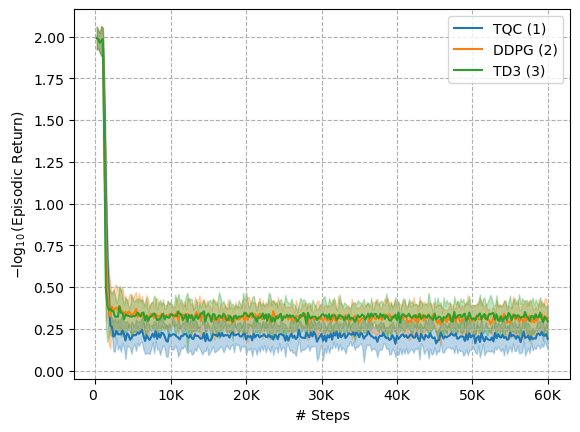

In [9]:
with multiprocessing.Pool(processes=os.cpu_count()) as pool:
    results = pool.map(parallel_retrieve_data, algos)

data = {algo: result for algo, result in results}
selected_algos = retrieve_best_algos(
    algos, data, threshold=THRESHOLD, top_k=TOP_K, log=LOG
)

fig, ax = plt.subplots()

for idx, algo in enumerate(selected_algos):
    episodes, _, means, std_devs, _, _ = retrieve_plot_data(
        data, algo, log=LOG
    )
    global_steps = [200 * x for x in episodes]
    (line,) = plt.plot(global_steps, means, label=f"{algo.upper()} ({idx+1})")
    plt.fill_between(
        global_steps,
        np.array(means) - np.array(std_devs),
        np.array(means) + np.array(std_devs),
        color=line.get_color(),
        alpha=0.3,
    )

plt.xlabel("# Steps")
plt.ylabel("$-\log_{10}\mathrm{(Episodic~Return)}$")
plt.grid(True, which="both", ls="--")
plt.legend()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.show()